In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, models

AUTOTUNE = tf.data.AUTOTUNE


The main benefit of using AUTOTUNE is that it can improve the efficiency and speed of data input pipelines, which is crucial for training models faster and more efficiently.

### Loading Data

In [ ]:
# Use tfds.builder to create the dataset builder
div2k_builder = tfds.builder('div2k', config='bicubic_x4')

# Download and prepare the dataset
div2k_builder.download_and_prepare()

# Load train and validation data
train_full = div2k_builder.as_dataset(split="train", as_supervised=True)
val_full = div2k_builder.as_dataset(split="validation", as_supervised=True)

# Take full data
train = train_full.take(800)  #  800 images
val = val_full.take(100)  #  100 images

# Cache the datasets
train_cache = train.cache()
val_cache = val.cache()
#The cache() method caches the training and validation datasets in memory,
# which can significantly speed up the training process by avoiding redundant
# data loading and preprocessing.

Bicubic: This term indicates that bicubic interpolation has been used to downscale the images. Bicubic interpolation is a method of resampling images which considers the closest 4x4 neighborhood of known pixel values around the target pixel. This method results in smoother images compared to nearest-neighbor or bilinear interpolation.

x4: This indicates the scaling factor. In this case, the images are downscaled by a factor of 4. For example, an image with original dimensions of 2048x2048 pixels would be downscaled to 512x512 pixels.

Thus, bicubic_x4 means the images in the DIV2K dataset have been downscaled by a factor of 4 using bicubic interpolation. This configuration is commonly used in super-resolution tasks, where the goal is to take a low-resolution image and predict its high-resolution counterpart.

### Data Preparation

In [ ]:
def flip_left_right(lowres_img, highres_img):
    """Flips Images to left and right."""
    #Flipping with a 50% probability keeps the original distribution while still augmenting the data.
    # Outputs random values from a uniform distribution in between 0 to 1
    rn = tf.random.uniform(shape=(), maxval=1)
    # If rn is less than 0.5 it returns original lowres_img and highres_img
    # If rn is greater than 0.5 it returns flipped image
    return tf.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            tf.image.flip_left_right(lowres_img),
            tf.image.flip_left_right(highres_img),
        ),
    )

In [ ]:
def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    # Outputs random values from uniform distribution in between 0 to 4
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    # Here rn signifies number of times the image(s) are rotated by 90 degrees
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)

In [ ]:
def random_crop(lowres_img, highres_img, lr_crop_size=48, scale=4):
    """Crop images.

    low resolution images: 48x48
    high resolution images: 192x192
    """
    hr_crop_size = lr_crop_size * scale
    lowres_img_shape = tf.shape(lowres_img)[:2]

    lowres_width = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[1] - lr_crop_size + 1, dtype=tf.int32
    )
    lowres_height = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[0] - lr_crop_size + 1, dtype=tf.int32
    )

    highres_width = lowres_width * scale
    highres_height = lowres_height * scale

    lowres_img_cropped = lowres_img[
        lowres_height : lowres_height + lr_crop_size,
        lowres_width : lowres_width + lr_crop_size,
    ]  # 48x48
    highres_img_cropped = highres_img[
        highres_height : highres_height + hr_crop_size,
        highres_width : highres_width + hr_crop_size,
    ]  # 192x192

    return lowres_img_cropped, highres_img_cropped

One time we calculate the mean RGB, next time dont run this cell

In [ ]:

def calculate_mean_rgb(dataset):
    """Calculate the mean RGB values of the dataset."""
    total_sum = np.zeros(3, dtype=np.float64)  # Initialize total sum for RGB channels
    total_pixels = 0  # Initialize total number of pixels

    for lowres, highres in tfds.as_numpy(dataset):
        lowres = lowres.astype(np.float64)
        highres = highres.astype(np.float64)

        # Sum the RGB values
        total_sum += np.sum(lowres, axis=(0, 1))
        total_sum += np.sum(highres, axis=(0, 1))

        # Count the total number of pixels
        total_pixels += (lowres.shape[0] * lowres.shape[1])
        total_pixels += (highres.shape[0] * highres.shape[1])

    mean_rgb = total_sum / (total_pixels * 3)  # Ensure total_pixels is float
    return mean_rgb



# Combine training and validation datasets for mean calculation
full_dataset = train_full.concatenate(val_full)

# Calculate mean RGB values
mean_rgb = calculate_mean_rgb(full_dataset)

print("Mean RGB values:", mean_rgb)


Mean RGB values: [37.98035411 37.11647683 34.36908292]


In [ ]:
mean_rgb = [37.98035411 ,37.11647683, 34.36908292]
def subtract_mean_rgb(lowres_img, highres_img, mean_rgb):
    """Subtract mean RGB value."""
    lowres_img = tf.cast(lowres_img, tf.float32) - mean_rgb
    highres_img = tf.cast(highres_img, tf.float32) - mean_rgb
    return lowres_img, highres_img


In [ ]:
def dataset_object(dataset_cache, mean_rgb, training=True):
    ds = dataset_cache
    ds = ds.map(
        lambda lowres, highres: random_crop(lowres, highres, lr_crop_size=48, scale=4),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )

    if training:
        ds = ds.map(random_rotate, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.map(flip_left_right, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    ds = ds.map(lambda lowres, highres: subtract_mean_rgb(lowres, highres, mean_rgb), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.batch(16)

    if training:
        ds = ds.repeat()

    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds


train_ds = dataset_object(train_cache, mean_rgb, training=True)
val_ds = dataset_object(val_cache, mean_rgb, training=False)

We use the RGB input patches of size
 48*48 from LR image with the corresponding HR patches.
 We augment the training data with random horizontal flips
 and 90 rotations.We pre-process all the images by subtract
ing the mean RGB value of the DIV2K dataset.

## Visualize the data

Let's visualize a few sample images:

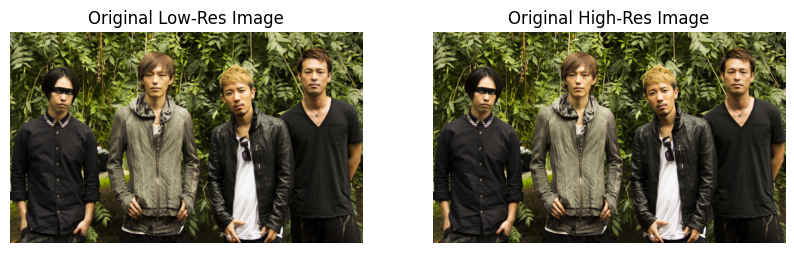

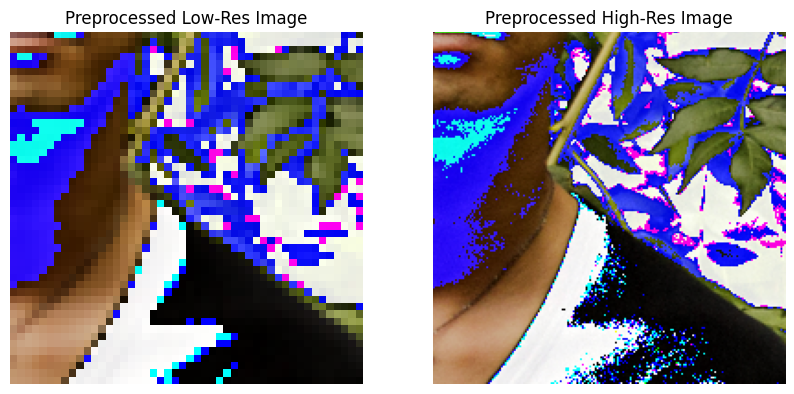

In [ ]:
 # Function to preprocess a single image pair
def preprocess_image_pair(lowres_img, highres_img, mean_rgb, training=True):
    lowres_img, highres_img = random_crop(lowres_img, highres_img, lr_crop_size=48, scale=4)
    if training:
        lowres_img, highres_img = random_rotate(lowres_img, highres_img)
        lowres_img, highres_img = flip_left_right(lowres_img, highres_img)
    lowres_img, highres_img = subtract_mean_rgb(lowres_img, highres_img, mean_rgb)
    return lowres_img, highres_img



# Load a single example from the dataset
#train_full = div2k_builder.as_dataset(split="train", as_supervised=True)
example_lowres, example_highres = next(iter(train_cache))


# Visualize the original images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(example_lowres.numpy().astype("uint8"))
plt.title("Original Low-Res Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(example_highres.numpy().astype("uint8"))
plt.title("Original High-Res Image")
plt.axis("off")

plt.show()

# Apply preprocessing
preprocessed_lowres, preprocessed_highres = preprocess_image_pair(example_lowres, example_highres, mean_rgb, training=True)

# Visualize the preprocessed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(preprocessed_lowres.numpy().astype("uint8"))
plt.title("Preprocessed Low-Res Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_highres.numpy().astype("uint8"))
plt.title("Preprocessed High-Res Image")
plt.axis("off")

plt.show()


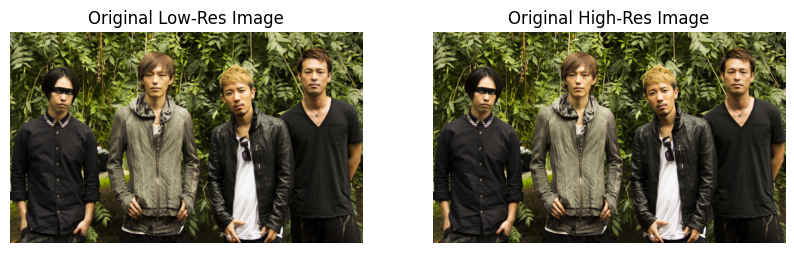

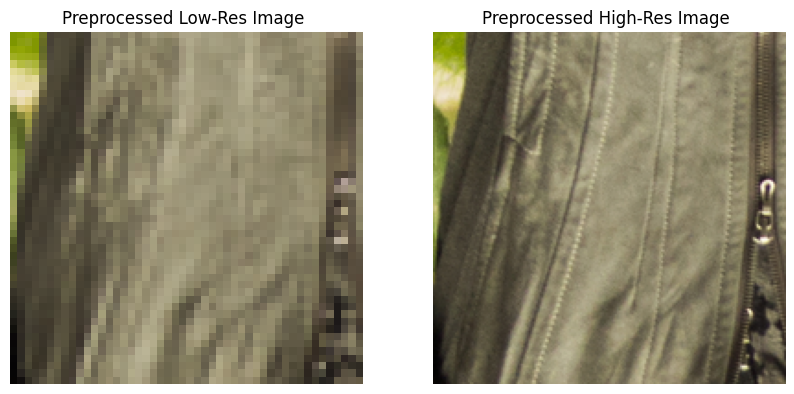

In [ ]:
#(No Mean Subtraction)

# Function to preprocess a single image pair without mean subtraction
def preprocess_image_pair_no_mean(lowres_img, highres_img, training=True):
    lowres_img, highres_img = random_crop(lowres_img, highres_img, lr_crop_size=48, scale=4)
    if training:
        lowres_img, highres_img = random_rotate(lowres_img, highres_img)
        lowres_img, highres_img = flip_left_right(lowres_img, highres_img)
    return lowres_img, highres_img




example_lowres, example_highres = next(iter(train_cache))

# Visualize the original images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(example_lowres.numpy().astype("uint8"))
plt.title("Original Low-Res Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(example_highres.numpy().astype("uint8"))
plt.title("Original High-Res Image")
plt.axis("off")

plt.show()

# Apply preprocessing without mean subtraction
preprocessed_lowres_no_mean, preprocessed_highres_no_mean = preprocess_image_pair_no_mean(example_lowres, example_highres, training=True)

# Visualize the preprocessed images without mean subtraction
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(preprocessed_lowres_no_mean.numpy().astype("uint8"))
plt.title("Preprocessed Low-Res Image ")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_highres_no_mean.numpy().astype("uint8"))
plt.title("Preprocessed High-Res Image ")
plt.axis("off")

plt.show()


### Build the Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics

# Define the PSNR Metric using a lambda function
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=255)

# Define EDSR Model Class
class EDSRModel(tf.keras.Model):
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, x):
        x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
        super_resolution_img = self(x, training=False)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)
        super_resolution_img = tf.round(super_resolution_img)
        super_resolution_img = tf.squeeze(tf.cast(super_resolution_img, tf.uint8), axis=0)
        return super_resolution_img

# Residual Block
def ResBlock(inputs):
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(32, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x

# Upsampling Block
class Upsampling(layers.Layer):
    def __init__(self, factor=2, **kwargs):
        super(Upsampling, self).__init__(**kwargs)
        self.factor = factor
        self.conv1 = layers.Conv2D(32 * (factor ** 2), 3, padding="same")
        self.conv2 = layers.Conv2D(32 * (factor ** 2), 3, padding="same")

    def call(self, inputs):
        x = self.conv1(inputs)
        x = tf.nn.depth_to_space(x, block_size=self.factor)
        x = self.conv2(x)
        x = tf.nn.depth_to_space(x, block_size=self.factor)
        return x

# Create the EDSR Model
def make_model(num_filters, num_of_residual_blocks):
    input_layer = layers.Input(shape=(None, None, 3))
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling()(x)  # Using the custom Upsampling layer
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = layers.Rescaling(scale=255)(x)
    return EDSRModel(input_layer, output_layer)

model = make_model(num_filters=32, num_of_residual_blocks=8)

# Define the Optimizer with Learning Rate Schedule
optim_edsr = optimizers.Adam(
    learning_rate=optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)

# Compile the Model
model.compile(optimizer=optim_edsr, loss="mae", metrics=[psnr])



import pickle

# Train the model
history = model.fit(
    train_ds,
    epochs=50,
    steps_per_epoch=100,
    validation_data=val_ds
)

# Save the history
with open('edsr_scale4_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

model.save('edsr_scale4_model.h5')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:607: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:582: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


100/100 ━━━━━━━━━━━━━━━━━━━━ 96s 722ms/step - psnr: 13.4348 - loss: 44.0043 - val_loss: 18.8066 - val_psnr: 20.0217
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - psnr: 20.8465 - loss: 72.3535 - val_loss: 14.2258 - val_psnr: 22.1033
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - psnr: 22.4553 - loss: 69.9850 - val_loss: 13.6580 - val_psnr: 22.9197
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - psnr: 23.3720 - loss: 73.8754 - val_loss: 12.3727 - val_psnr: 23.8884
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - psnr: 24.0856 - loss: 73.1212 - val_loss: 10.2936 - val_psnr: 25.1929
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - psnr: 24.7228 - loss: 73.5351 - val_loss: 11.1266 - val_psnr: 24.8513
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - psnr: 25.1371 - loss: 71.2713 - val_loss: 9.7081 - val_psnr: 25.9227
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - psnr: 25.4753 - loss: 72.3169 - val_loss: 10.1189 - val_psnr: 25.7275
Epoch 9/50

In [ ]:
model.save('edsr_scale4_model.h5')

Save the Training History:

In [ ]:
import pickle

# Train the model
history = model.fit(
    train_ds,
    epochs=50,
    steps_per_epoch=100,
    validation_data=val_ds
)

# Save the history
with open('edsr_scale2_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [ ]:
import pickle
import matplotlib.pyplot as plt

# Load the history
with open('edsr_scale2_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Plot PSNR
plt.plot(history['psnr'])
plt.plot(history['val_psnr'])
plt.title('Model PSNR')
plt.ylabel('PSNR')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot Loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


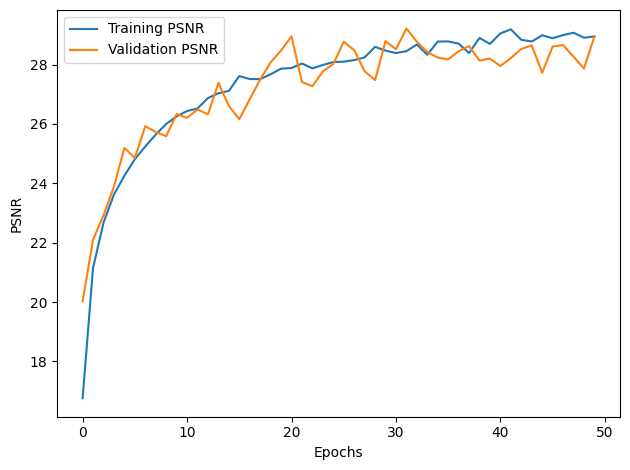

In [ ]:

# Plotting training and validation PSNR

plt.plot(history.history['psnr'], label='Training PSNR')
plt.plot(history.history['val_psnr'], label='Validation PSNR')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
#plt.title('Training and Validation PSNR')
plt.legend()

plt.tight_layout()
plt.show()

### Visualization

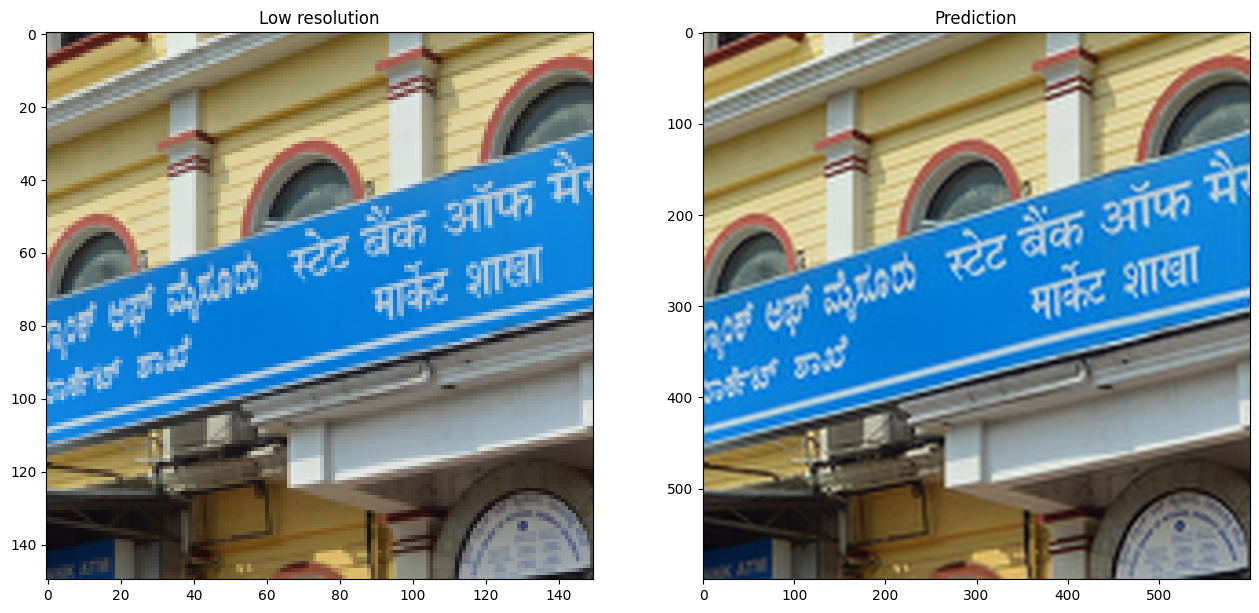

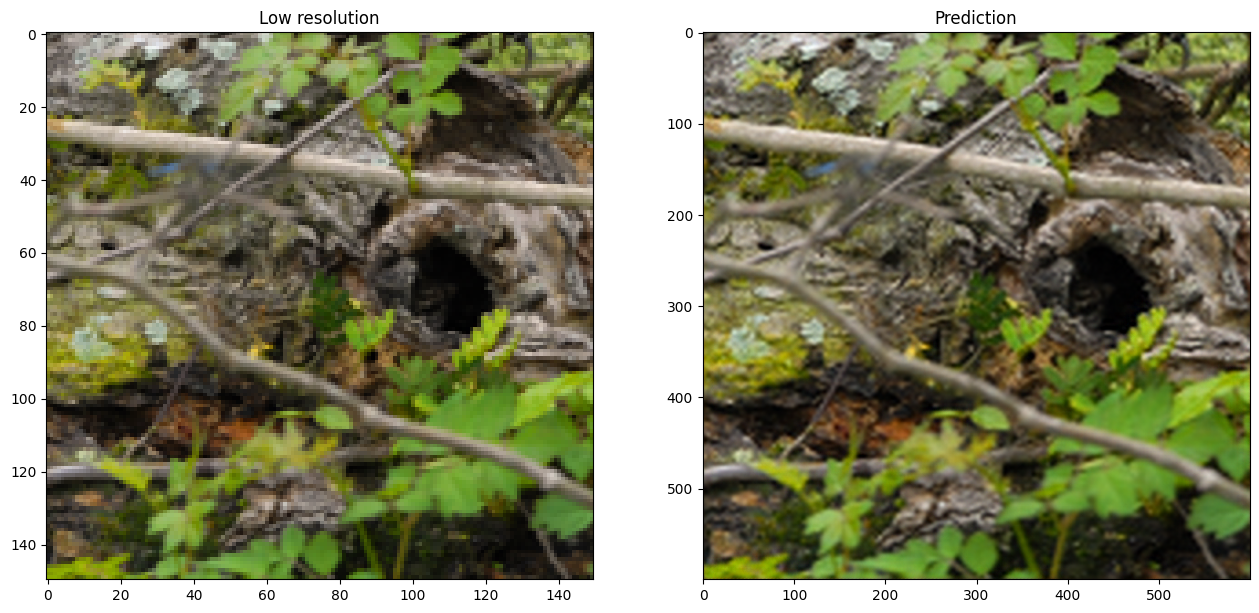

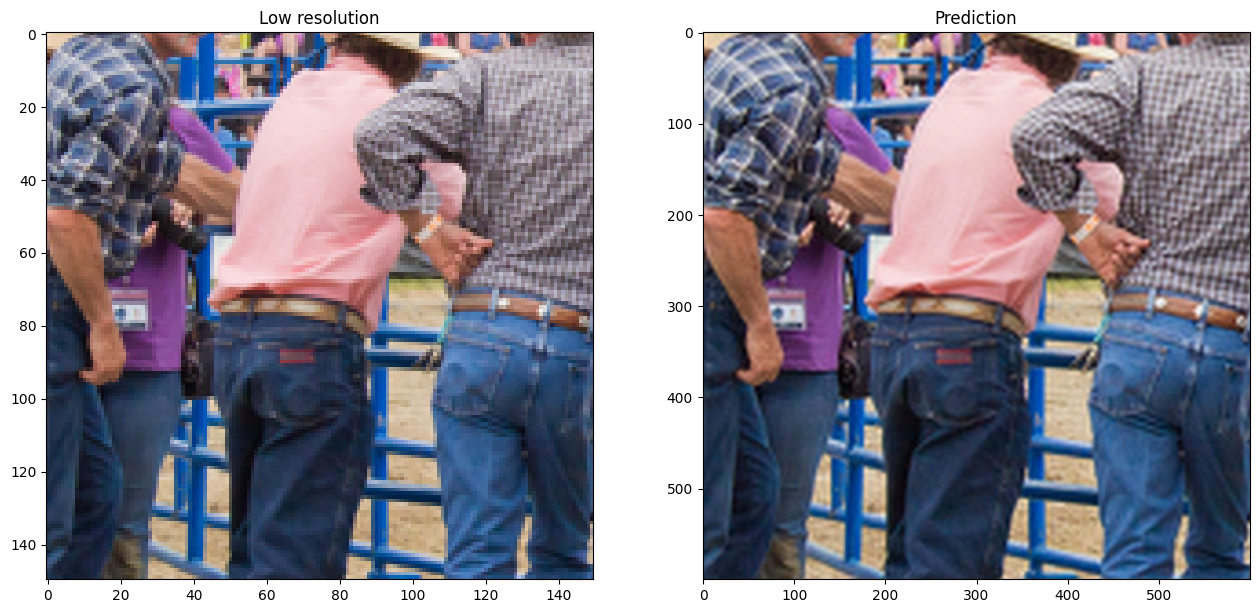

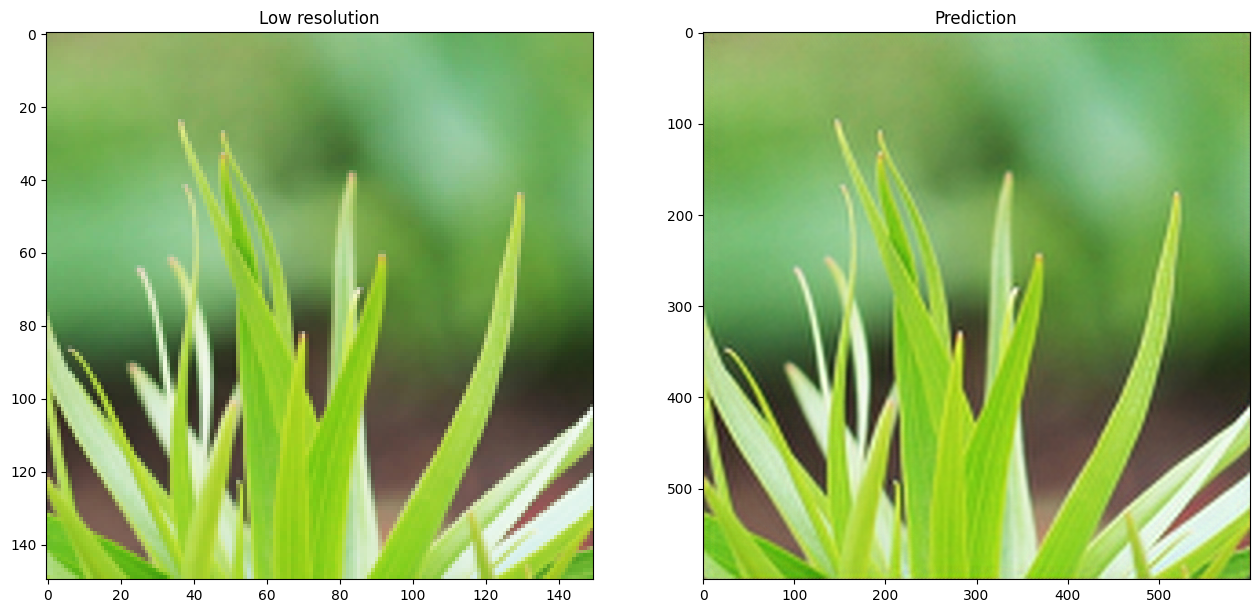

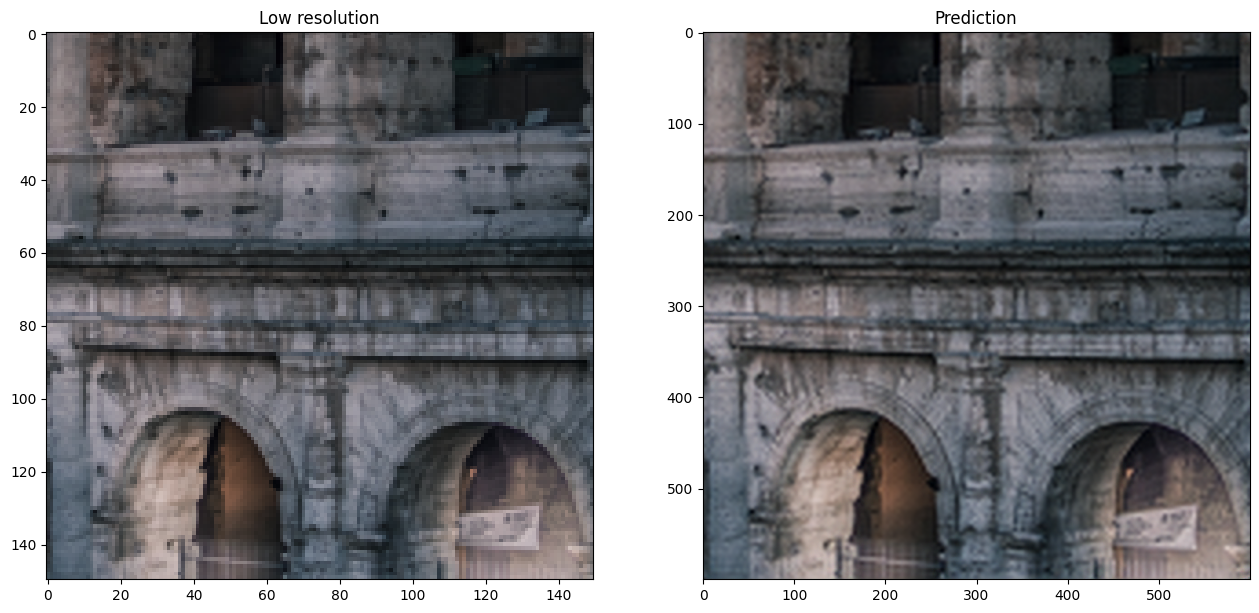

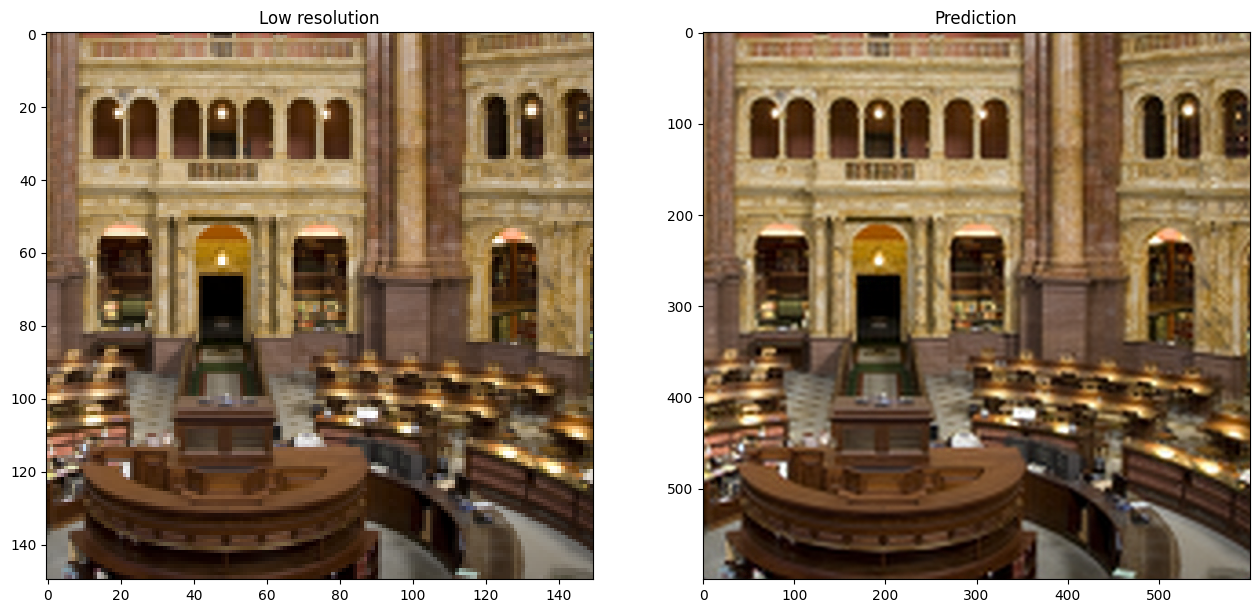

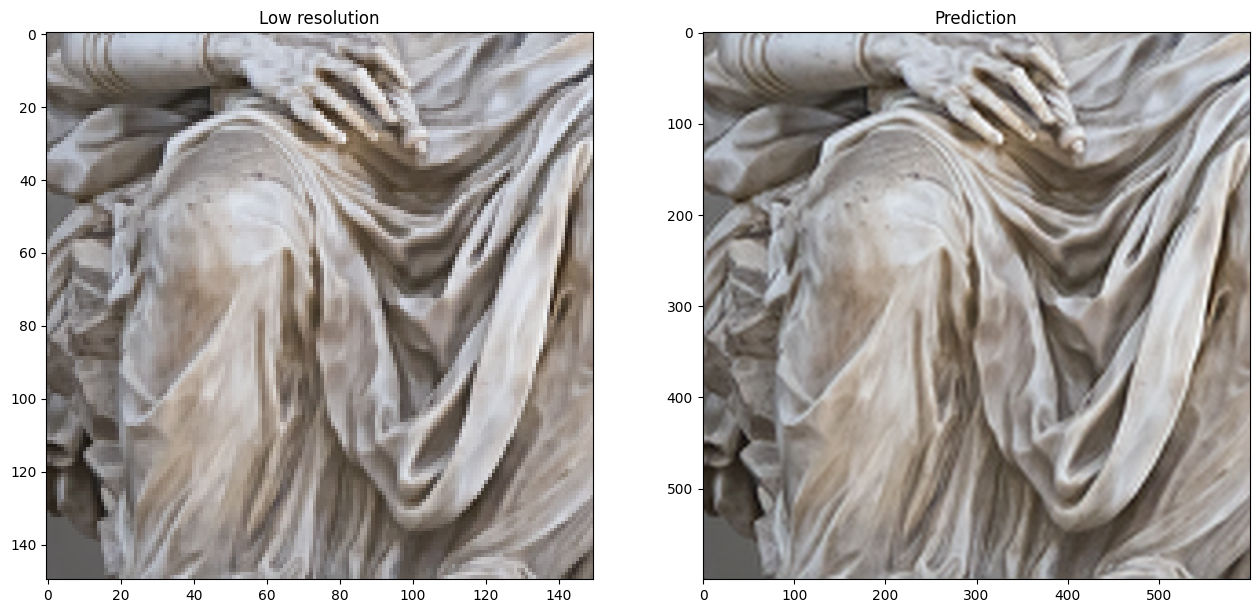

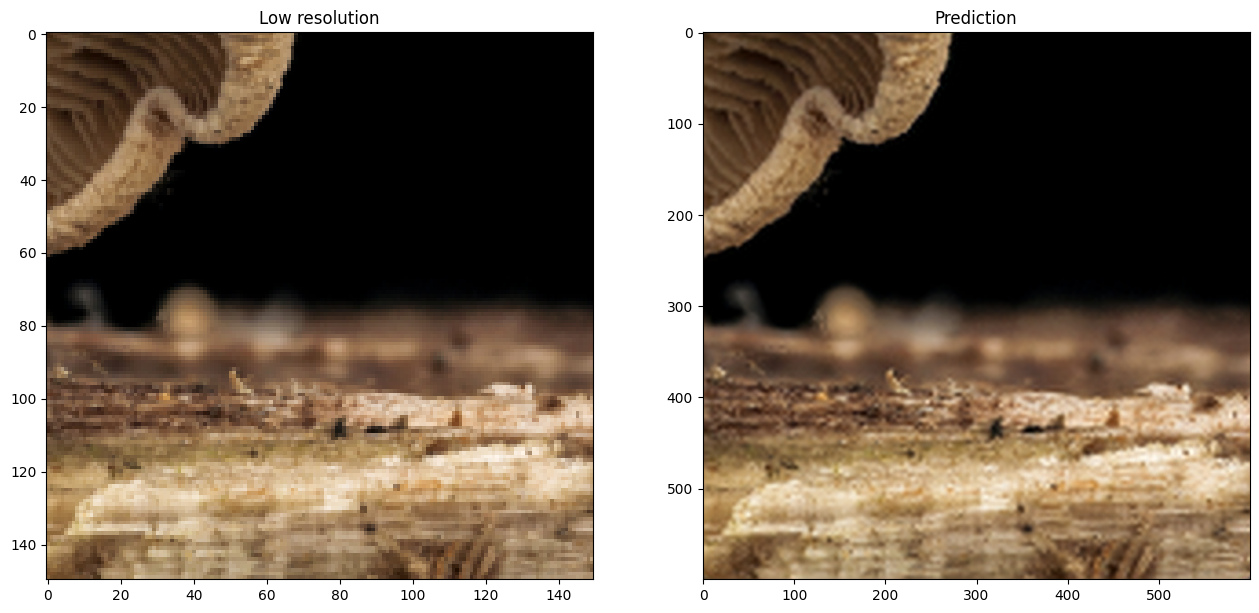

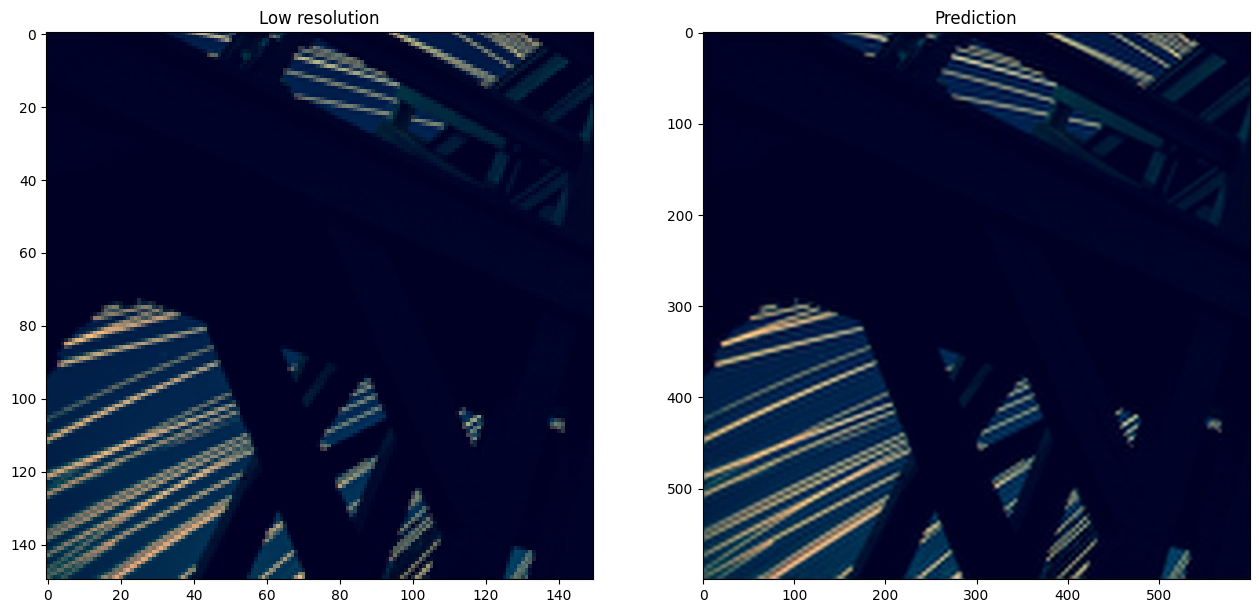

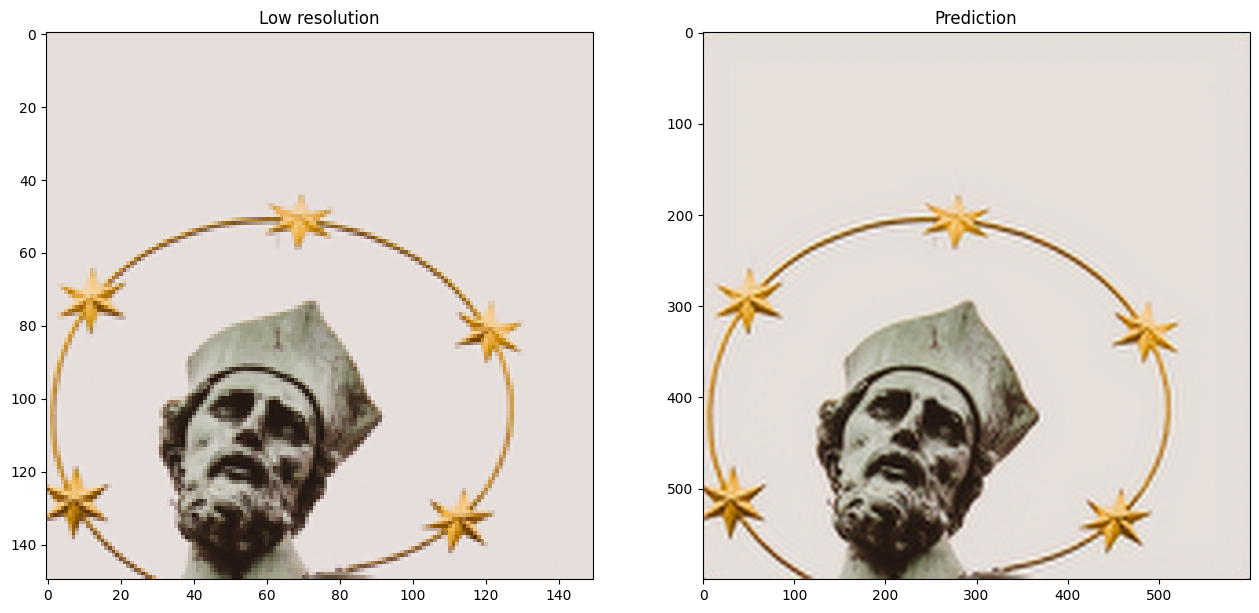

In [ ]:
def plot_results(lowres, preds):
    """
    Displays low resolution image and super resolution image
    """
    plt.figure(figsize=(24, 14))
    plt.subplot(132), plt.imshow(lowres), plt.title("Low resolution")
    plt.subplot(133), plt.imshow(preds), plt.title("Prediction")
    plt.show()


for lowres, highres in val_cache.take(10):
    lowres = tf.image.random_crop(lowres, (150, 150, 3))
    preds = model.predict_step(lowres)
    plot_results(lowres, preds)

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Function to preprocess a single image pair without mean subtraction
def preprocess_image_pair_no_mean(lowres_img, highres_img, training=True):
    lowres_img, highres_img = random_crop(lowres_img, highres_img, lr_crop_size=48, scale=4)
    if training:
        lowres_img, highres_img = random_rotate(lowres_img, highres_img)
        lowres_img, highres_img = flip_left_right(lowres_img, highres_img)
    return lowres_img, highres_img



def plot_results(lowres, highres, preds):
    """
    Displays low-resolution image, high-resolution image, and super-resolution image
    """
    plt.figure(figsize=(24, 14))

    plt.subplot(132)
    plt.imshow(lowres)
    plt.title("Low resolution")
    plt.axis("off")

    plt.subplot(131)
    plt.imshow(highres)
    plt.title("High resolution")
    plt.axis("off")

    plt.subplot(133)
    plt.imshow(preds)
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

# Loop through a few samples from the validation set
for lowres, highres in val_cache.take(20):
    lowres = tf.image.random_crop(lowres, (150, 150, 3))
    preprocessed_lowres, _ = preprocess_image_pair_no_mean(lowres, highres, training=False)
    #preds = model.predict_step(preprocessed_lowres)
    preds = model.predict_step(lowres)
    plot_results(lowres.numpy().astype("uint8"), highres.numpy().astype("uint8"), preds.numpy().astype("uint8"))
